<a href="https://colab.research.google.com/github/Redcxx/ucl-master-project/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings

## Environment

In [1]:
%pip install pydrive2
%pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import sys
import time
import random
import functools
import subprocess
from pathlib import Path
from pprint import pprint
from datetime import datetime

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchinfo import summary

## Configuration

In [3]:
class SessionConfig(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self  # dangerous, merging namespace, but now you can access key using .key instead of ['key']

        # House keeping
        self.tag = 'colorization'
        self.run_id = f'{self.tag}-' + datetime.now().strftime('%Y-%m-%d-%A-%Hh-%Mm-%Ss')
        self.random_seed = 42
        self.working_folder = 'MasterProject'  # will be created on google drive at root
        self.pydrive2_setting_file = 'settings.yaml'

        # Dataset
        self.dataset_dir = './datasets'
        self.dataset_name = 'edges2shoes'  # default facades, edges2handbags is 8g (long time to download), edges2shoes is 2g
        self.batch_size = 32  # default 1
        self.shuffle = False
        self.num_workers = 4
        self.pin_memory = True
        self.A_to_B = True
        # transforms
        self.random_jitter = True
        self.random_mirror = True

        # Training
        self.start_epoch = 1
        self.end_epoch = 10   # default 200
        self.eval_freq = 3   # eval frequency, unit epoch
        self.log_freq = 1    # log frequency, unit epoch
        self.save_freq = 1  # save checkpoint, unit epoch
        self.batch_log_freq = 1000

        # Evalute
        self.n_eval_display_samples = 3

        # Model
        self.generator_config = None
        self.discriminator_config = None

        # Optimizer
        self.lr = 0.0002
        self.optimizer_beta1 = 0.9   # default 0.5
        self.optimizer_beta2 = 0.999
        self.init_gain = 0.02  # default 0.02
        self.weight_decay = 0  # default 0

        # Scheduler
        self.epochs_decay = 5  # default 100
        
        # Loss
        self.l1_lambda = 100.0    # encourage l1 distance to actual output
        self.d_loss_factor = 0.5  # slow down discrminator learning

        self.update(dict(*args, **kwargs))

generator_config = {
    'in_channels': 3,
    'out_channels': 3,
    'blocks': [
    {
        'filters': 64,
        'dropout': False,
        'skip_connection': False
    }, 
    {
        'filters': 128,
        'dropout': False,
        'skip_connection': True
    }, 
    {
        'filters': 256,
        'dropout': False,
        'skip_connection': True
    }, 
    {
        'filters': 512,
        'dropout': True,
        'skip_connection': True
    }, 
    {
        'filters': 512,
        'dropout': True,
        'skip_connection': True
    }, 
    {
        'filters': 512,
        'dropout': True,
        'skip_connection': True
    }, 
    {
        'filters': 512,
        'dropout': False,
        'skip_connection': True
    }]
}

discriminator_config = {
    'in_channels': 3 * 2,  # conditionalGAN takes both real and fake image
    'blocks': [
    {
        'filters': 64,
    }, 
    {
        'filters': 128,
    }, 
    {
        'filters': 256,
    }, 
    {
        'filters': 512,
    }]
}


sconfig = SessionConfig({
    'generator_config': generator_config,
    'discriminator_config':discriminator_config,
})

pprint(sconfig)

{'A_to_B': True,
 'batch_log_freq': 1000,
 'batch_size': 4,
 'd_loss_factor': 0.5,
 'dataset_dir': './datasets',
 'dataset_name': 'edges2shoes',
 'discriminator_config': {'blocks': [{'filters': 64},
                                     {'filters': 128},
                                     {'filters': 256},
                                     {'filters': 512}],
                          'in_channels': 6},
 'end_epoch': 15,
 'epochs_decay': 5,
 'eval_freq': 3,
 'generator_config': {'blocks': [{'dropout': False,
                                  'filters': 64,
                                  'skip_connection': False},
                                 {'dropout': False,
                                  'filters': 128,
                                  'skip_connection': True},
                                 {'dropout': False,
                                  'filters': 256,
                                  'skip_connection': True},
                                 {'dropout': True

## Saving and Loading

In [4]:
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import files, drive

    drive_dir = '/content/drive'
    drive.mount(drive_dir)

    working_dir = os.path.join(drive_dir, 'My Drive', sconfig.working_folder, sconfig.run_id)
    print(working_dir)
    Path(working_dir).mkdir(parents=True, exist_ok=True)  # create directory if not exists on google drive

    def save_file(file_name, local=True):
        # save locally
        if local:
            files.download(file_name)  

        # save on google drive
        with open(file_name, 'rb') as src_file:
            with open(os.path.join(working_dir, file_name), 'wb') as dest_file:
                dest_file.write(src_file.read())
    
    def load_file(file_name):
        if os.path.isfile(file_name):
            print(f'"{file_name}" already exists, not downloading')
            return True
        exit_code = subprocess.call(f'cp "{os.path.join(working_dir, file_name)}" "{file_name}"')
        if exit_code is None:
            # did not terminate
            return False
        return exit_code >= 0


else:
    from pydrive2.auth import GoogleAuth
    from pydrive2.drive import GoogleDrive

    def ensure_folder_on_drive(drive, folder_name):
        folders = drive.ListFile({
            # see https://developers.google.com/drive/api/guides/search-files
            'q': "mimeType = 'application/vnd.google-apps.folder'"
        }).GetList()

        folders = list(filter(lambda folder: folder['title'] == folder_name, folders))

        if len(folders) == 1:
            return folders[0]
        
        if len(folders) > 1:
            pprint(folders)
            raise AssertionError('Multiple Folders of the same name detected')

        # folder not found, create a new one at root
        print(f'Folder: {folder_name} not found, creating at root')

        folder = drive.CreateFile({
            'title': folder_name, 
            # "parents": [{
            #     "kind": "drive#fileLink", 
            #     "id": parent_folder_id
            # }],
            "mimeType": "application/vnd.google-apps.folder"
        })
        folder.Upload()
        return folder


    g_auth = GoogleAuth(settings_file=sconfig.pydrive2_setting_file, http_timeout=None)
    g_auth.LocalWebserverAuth(host_name="localhost", port_numbers=None, launch_browser=True)
    drive = GoogleDrive(g_auth)

    folder = ensure_folder_on_drive(drive, sconfig.working_folder)    

    def save_file(file_name, local=True):
        file = drive.CreateFile({
            'title': file_name,
            'parents': [{
                'id': folder['id']
            }]
        })
        file.SetContentFile(file_name)
        # save to google drive
        file.Upload()
        # save locally
        if local:
            file.GetContentFile(file_name)
    
    def load_file(file_name):
        if os.path.isfile(file_name):
            print(f'"{file_name}" already exists, not downloading')
            return True
        files = drive.ListFile({
            'q': f"'{folder['id']}' in parents"
        }).GetList()
        downloaded = 1
        for file in files:
            if file['title'] == file_name:
                # download
                drive.CreateFile({'id': file['id']}).GetContentFile(file_name)
                return True
        return False  # no match file


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MasterProject/colorization-2022-05-29-Sunday-10h-09m-51s


## Reproducibility

In [5]:
random.seed(sconfig.random_seed)
np.random.seed(sconfig.random_seed)
torch.manual_seed(sconfig.random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(sconfig.random_seed)

## Device

In [6]:
# training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [7]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Models

## UnetBlock

In [8]:
class UnetBlock(nn.Module):
    def __init__(
        self, 
        in_filters, out_filters,

        submodule=None, 
        sub_in_filters=None, 
        sub_out_filters=None, 
        sub_skip_connection=False, 

        skip_connection=True, 
        dropout=nn.Dropout, 
        in_norm=nn.BatchNorm2d, out_norm=nn.BatchNorm2d, 
        in_act=nn.LeakyReLU, out_act=nn.ReLU,
    ):
        super().__init__()

        if submodule is None:
            sub_in_filters = in_filters
            sub_out_filters = in_filters
            sub_skip_connection = False
        
        conv_common_args = {
            'kernel_size': 4, 
            'stride': 2, 
            'padding': 1,
            'bias': in_norm.func != nn.BatchNorm2d if type(in_norm) == functools.partial else in_norm != nn.BatchNorm2d  # batch norm has bias
        }

        layers = []

        # encoder
        layers.append(nn.Conv2d(in_channels=in_filters, out_channels=sub_in_filters, **conv_common_args))

        if in_norm:
            layers.append(in_norm(sub_in_filters))

        if in_act:
            layers.append(in_act())

        
        # submodule
        if submodule:
            layers.append(submodule)


        # decoder
        if sub_skip_connection:
            layers.append(nn.ConvTranspose2d(in_channels=sub_out_filters * 2, out_channels=out_filters, **conv_common_args))
        else:
            layers.append(nn.ConvTranspose2d(in_channels=sub_out_filters    , out_channels=out_filters, **conv_common_args))

        if out_norm:
            layers.append(out_norm(out_filters))
        
        if dropout:
            layers.append(dropout())
        
        if out_act:
            layers.append(out_act())
        
        self.model = nn.Sequential(*layers)

        self.skip_connection = skip_connection
    
    def forward(self, x):
        if self.skip_connection:
            return torch.cat([x, self.model(x)], dim=1)
        else:
            return self.model(x)

In [9]:
# summary(
#     UnetBlock(in_filters=64, out_filters=64, submodule=None), 
#     input_size=(16, 64, 16, 16),
#     col_names=['output_size', 'num_params', 'mult_adds']
# )

## Generator

In [10]:
class Generator(nn.Module):

    def __init__(self, config):
        super().__init__()

        # dependency injection
        batch_norm = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
        relu = functools.partial(nn.ReLU, inplace=True)
        leaky_relu = functools.partial(nn.LeakyReLU, inplace=True, negative_slope=0.2)
        dropout = functools.partial(nn.Dropout, p=0.5)
        tahn = nn.Tanh
        
        # build model recursively inside-out
        blocks = config['blocks'][::-1]  

        self.model = None

        # build innermost block
        self.model = UnetBlock(
            in_filters=blocks[0]['filters'], 
            out_filters=blocks[0]['filters'],

            submodule=None, 
            sub_in_filters=None, 
            sub_out_filters=None,
            sub_skip_connection=False,

            skip_connection=blocks[0]['skip_connection'],
            dropout=dropout if blocks[0]['dropout'] else None,
            in_norm=None, out_norm=False,
            in_act=relu, out_act=relu
        )
        
        # build between blocks
        for i, layer in enumerate(blocks[1:], 1):
            self.model = UnetBlock(
                in_filters=layer['filters'], 
                out_filters=layer['filters'],

                submodule=self.model, 
                sub_in_filters=blocks[i-1]['filters'], 
                sub_out_filters=blocks[i-1]['filters'],
                sub_skip_connection=blocks[i-1]['skip_connection'],

                skip_connection=blocks[i]['skip_connection'],
                dropout=dropout if layer['dropout'] else None,
                in_norm=batch_norm, out_norm=batch_norm,
                in_act=leaky_relu, out_act=relu
            )
        
        # build outermost block
        self.model = UnetBlock(
            in_filters=config['in_channels'],
            out_filters=config['out_channels'],

            submodule=self.model,
            sub_in_filters=blocks[-1]['filters'], 
            sub_out_filters=blocks[-1]['filters'],
            sub_skip_connection=blocks[-1]['skip_connection'],

            skip_connection=blocks[-1]['skip_connection'], 
            dropout=None,
            in_norm=None, out_norm=None,
            in_act=leaky_relu, out_act=tahn
        )

    def forward(self, x):
        return self.model(x)


In [11]:
# summary(
#     Generator(generator_config),
#     input_size=(16, 3, 256, 256),
#     col_names=['output_size', 'num_params', 'mult_adds'],
#     depth=24
# )

print(Generator(generator_config))

Generator(
  (model): UnetBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): UnetBlock(
        (model): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
          (3): UnetBlock(
            (model): Sequential(
              (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): LeakyReLU(negative_slope=0.2, inplace=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (1

## Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()

        # we do not use bias in conv2d layer if batch norm is used, because batch norm already has bias
        batch_norm = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
        leaky_relu = functools.partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)

        conv_common_args = {
            'kernel_size': 4, 
            'padding': 1,
        }

        blocks = config['blocks']
        layers = []

        # build first block
        layers += [
            nn.Conv2d(config['in_channels'], blocks[0]['filters'], stride=2, **conv_common_args),
            leaky_relu()
        ]

        # build between block
        prev_filters = blocks[0]['filters']
        for i, layer in enumerate(blocks[1:-1], 1):
            curr_filters = min(blocks[i]['filters'], blocks[0]['filters']*8)
            layers += [
                nn.Conv2d(prev_filters, curr_filters, bias=False, stride=2, **conv_common_args),
                batch_norm(curr_filters),
                leaky_relu()
            ]
            prev_filters = curr_filters

        # build last block
        curr_filters = min(blocks[-1]['filters'], blocks[0]['filters'] * 8)
        layers += [
            # stride = 1 for last block
            nn.Conv2d(prev_filters, curr_filters, stride=1, bias=False, **conv_common_args),
            batch_norm(curr_filters),
            leaky_relu(),
            # convert to 1 dimensional output
            nn.Conv2d(curr_filters, 1, stride=1, **conv_common_args)
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [13]:
# summary(
#     Discriminator(discriminator_config),
#     input_size=(16, 3, 256, 256),
#     col_names=['output_size', 'num_params', 'mult_adds'],
#     depth=24
# )

# Data

In [14]:
%%bash -s "$sconfig.dataset_name" "$sconfig.dataset_dir"

# this cell is taken directly from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_pix2pix_dataset.sh
# except that i moved mkdir before wget to ensure dataset dir always exists

FILE=$1
DATASET_DIR=$2

if [[ $FILE != "cityscapes" && $FILE != "night2day" && $FILE != "edges2handbags" && $FILE != "edges2shoes" && $FILE != "facades" && $FILE != "maps" ]]; then
  echo "Available datasets are cityscapes, night2day, edges2handbags, edges2shoes, facades, maps"
  exit 1
fi

if [[ $FILE == "cityscapes" ]]; then
    echo "Due to license issue, we cannot provide the Cityscapes dataset from our repository. Please download the Cityscapes dataset from https://cityscapes-dataset.com, and use the script ./datasets/prepare_cityscapes_dataset.py."
    echo "You need to download gtFine_trainvaltest.zip and leftImg8bit_trainvaltest.zip. For further instruction, please read ./datasets/prepare_cityscapes_dataset.py"
    exit 1
fi

echo "Specified [$FILE]"

URL=http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/$FILE.tar.gz
TAR_FILE=$DATASET_DIR/$FILE.tar.gz
TARGET_DIR=$DATASET_DIR/$FILE/


if [ -d $TARGET_DIR ]; then
    echo $TARGET_DIR exists, not downloading
else
    mkdir -p $TARGET_DIR
    wget -N $URL -O $TAR_FILE
    tar -zxvf $TAR_FILE -C ./datasets/
    rm $TAR_FILE
fi

Specified [edges2shoes]
./datasets/edges2shoes/ exists, not downloading


## Utilities

In [15]:
IMG_EXTENSIONS = [
    '.jpg', '.jpeg',
    '.png', '.ppm', '.bmp',
    '.tif', '.tiff',
]

def is_image_file(filename):
    return any(filename.lower().endswith(ext) for ext in IMG_EXTENSIONS)

def get_all_image_paths(root):
    paths = []
    assert os.path.isdir(root)

    for root, _, filenames in sorted(os.walk(root)):
        for filename in filenames:
            if is_image_file(filename):
                paths.append(os.path.join(root, filename))
    
    return paths

## Dataset

In [16]:
class MyDataset(Dataset):

    def __init__(self, root):
        self.paths = sorted(get_all_image_paths(root))
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, i):
        A, B = self._split_input_output(self._read_im(self.paths[i]))

        transform = self._generate_transform()

        A, B = transform(A), transform(B)  # apply same transform to both A and B
        
        return (A, B) if sconfig.A_to_B else (B, A)

    def _read_im(self, path):
        return Image.open(path).convert('RGB')

    def _split_input_output(self, AB):
        w, h = AB.size
        w2 = int(w / 2)
        A = AB.crop((0, 0, w2, h))
        B = AB.crop((w2, 0, w, h))

        return A, B

    def _generate_transform(self):
        additional_transforms = []

        if sconfig.random_jitter:

            new_size = 286
            old_size = 256

            rand_x = random.randint(0, new_size - old_size)
            rand_y = random.randint(0, new_size - old_size)

            additional_transforms += [
                    transforms.Resize((new_size, new_size), interpolation=InterpolationMode.BICUBIC, antialias=True),
                    transforms.Lambda(lambda im: self._crop(im, (rand_x, rand_y), (old_size, old_size)))
            ]
        
        if sconfig.random_mirror:
            flip = random.random() > 0.5
            additional_transforms += [
                transforms.Lambda(lambda im: self._flip(im, flip)),
            ]
        
        return transforms.Compose([
            *additional_transforms,
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])


    def _flip(self, im, flip):
        if flip:
            return im.transpose(Image.FLIP_LEFT_RIGHT)
        return im

    def _crop(self, im, pos, size):
        return im.crop((pos[0], pos[1], pos[0] + size[0], pos[1] + size[1]))

# Criterion

In [17]:
class GANLoss(nn.Module):

    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()

        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))

        self.loss = nn.BCEWithLogitsLoss() # nn.MSELoss()
    
    def __call__(self, model_output, target_is_real):

        label = self.real_label if target_is_real else self.fake_label
        label = label.expand_as(model_output)

        return self.loss(model_output, label)

# Evaluation

## Plot

In [18]:
def plot_im(tensor):
    im = tensor.squeeze().cpu().detach().numpy()
    im = unnormalize_im(im)
    im = im.transpose(1,2,0)
    plt.imshow(im)

def unnormalize_im(im):
    return np.clip(im * 0.5 + 0.5, 0, 1)

def plot_h_images(images, titles=None, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)

    for i, im in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plot_im(im)
        if titles:
            plt.title(titles[i])

    plt.show()

    return fig

def plot_inp_tar_out(inp, tar, out):
    return plot_h_images(
        [inp, tar, out],
        ['input', 'target', 'output'],
        (10, 10)
    )

## Evaluate

In [19]:
def evaluate(net_G, net_D, test_dataloader, criterion, n_display_samples=3):
    net_G.eval()
    net_D.eval()

    eval_losses = []
    for i, (inp, tar) in enumerate(test_dataloader):
        inp, tar = inp.to(device), tar.to(device)

        out = net_G(inp)
        loss = criterion(out, tar)
        eval_losses.append(loss.item())

        if i < n_display_samples:
            plot_inp_tar_out(inp, tar, out)
    
    return eval_losses

# Training

## Utilities

In [20]:
def format_time(seconds):
    return time.strftime('%Hh:%Mm:%Ss', time.gmtime(seconds))

def save_checkpoint(net_G, net_D, optimizer_G, optimizer_D, tag=''):
    file_name = f'{sconfig.run_id}{tag}.ckpt'
    torch.save({
        'net_G_state_dict': net_G.state_dict(),
        'net_D_state_dict': net_D.state_dict(),
        'net_G_optimizer_state_dict': optimizer_G.state_dict(),
        'net_D_optimizer_state_dict': optimizer_D.state_dict(),
        'session_config': sconfig
    }, file_name)
    save_file(file_name, local=False)
    return file_name

def load_checkpoint(run_id, tag=''):
    file_name = f'{run_id}{tag}.ckpt'
    if not load_file(file_name):  # ensure exists locally
        print(f'Failed to load checkpoint: {file_name}')
        return None
    checkpoint = torch.load(file_name)

    sconfig = checkpoint['session_config']

    net_G = Generator(sconfig.generator_config)
    net_D = Discriminator(sconfig.discriminator_config)
    net_G.load_state_dict(checkpoint['net_G_state_dict'])
    net_D.load_state_dict(checkpoint['net_D_state_dict'])

    optimizer_G = optim.Adam(net_G.parameters(), lr=sconfig.lr, betas=(sconfig.optimizer_beta1, sconfig.optimizer_beta2))
    optimizer_D = optim.Adam(net_D.parameters(), lr=sconfig.lr, betas=(sconfig.optimizer_beta1, sconfig.optimizer_beta2))
    optimizer_G.load_state_dict(checkpoint['net_G_optimizer_state_dict'])
    optimizer_D.load_state_dict(checkpoint['net_D_optimizer_state_dict'])

    return sconfig, net_G, net_D, optimizer_G, optimizer_D

def set_requires_grad(net, requires_grad):
    for param in net.parameters():
        param.requires_grad = requires_grad


In [21]:
def train_batch(net_G, net_D, optimizer_G, optimizer_D, real_A, real_B, criterion_gan, criterion_l1):

    # forward pass
    # generate fake image using generator
    fake_B = net_G(real_A)

    ###
    # DISCRMINATOR
    ###
    set_requires_grad(net_D, True)
    optimizer_D.zero_grad()

    # discrminate fake image
    fake_AB = torch.cat((real_A, fake_B), dim=1)  # conditionalGAN takes both real and fake image
    pred_fake = net_D(fake_AB.detach())
    loss_D_fake = criterion_gan(pred_fake, False)

    # discrminate real image
    real_AB = torch.cat((real_A, real_B), dim=1)
    pred_real = net_D(real_AB)
    loss_D_real = criterion_gan(pred_real, True)

    # backward & optimize
    loss_D = (loss_D_fake + loss_D_real) * sconfig.d_loss_factor
    loss_D.backward()
    optimizer_D.step()

    ###
    # GENERATOR
    ###
    set_requires_grad(net_D, False)
    optimizer_G.zero_grad()

    # generator should fool the discriminator
    fake_AB = torch.cat((real_A, fake_B), dim=1)
    pred_fake = net_D(fake_AB)
    loss_G_fake = criterion_gan(pred_fake, True)

    # l1 loss between generated and real image for more accurate output
    loss_G_l1 = criterion_l1(fake_B, real_B) * sconfig.l1_lambda

    # backward & optimize
    loss_G = loss_G_fake + loss_G_l1
    loss_G.backward()
    optimizer_G.step()

    return loss_G_fake.item(), loss_G_l1.item(), loss_D.item()

In [22]:
def lambda_rule(epoch):
    return 1.0 - max(0, epoch + sconfig.start_epoch - sconfig.end_epoch) / float(sconfig.epochs_decay + 1)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def init_weight(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 \
                                or classname.find('Linear') != -1 \
                                or classname.find('BatchNorm2d') != -1):
        nn.init.normal_(m.weight.data, 0.0, sconfig.init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

## Sanity Check

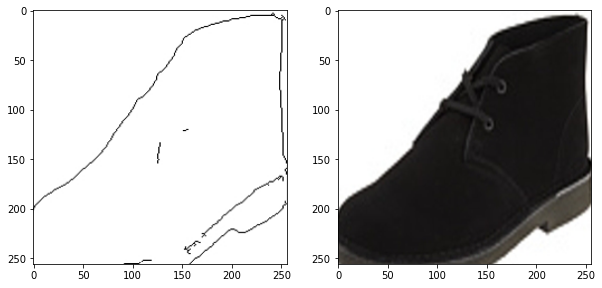

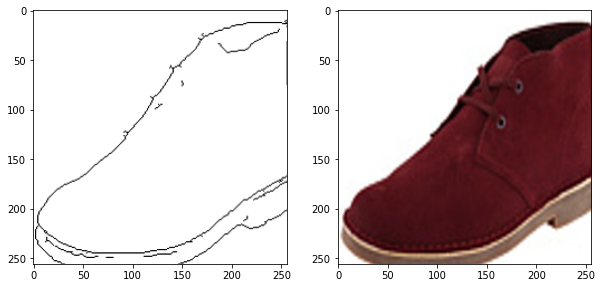

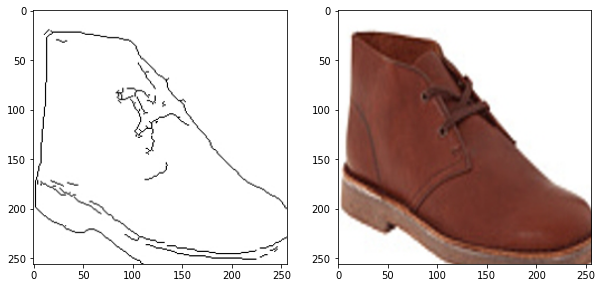

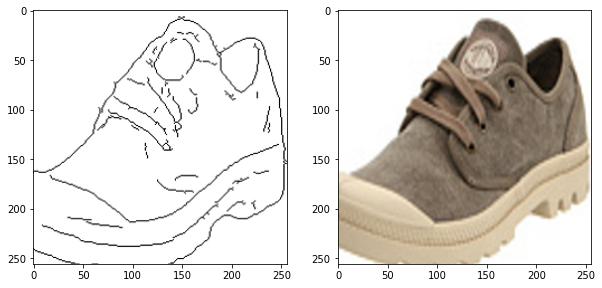

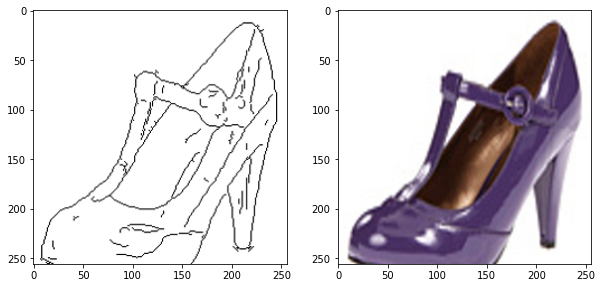

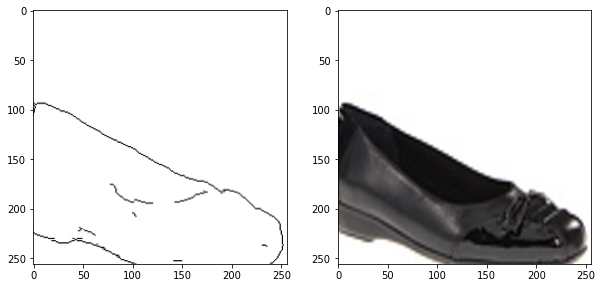

In [23]:
train_dataset = MyDataset(os.path.join(sconfig.dataset_dir, sconfig.dataset_name, 'train'))
test_dataset = MyDataset(os.path.join(sconfig.dataset_dir, sconfig.dataset_name, 'val'))

for i in range(3):
    plot_h_images(train_dataset[i])

for i in range(3):
    plot_h_images(test_dataset[i])

## Loop

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=sconfig.batch_size, shuffle=sconfig.shuffle, num_workers=sconfig.num_workers, pin_memory=sconfig.pin_memory)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=sconfig.num_workers, pin_memory=sconfig.pin_memory)

# TODO load check point if exists 

net_G = Generator(generator_config)
net_D = Discriminator(discriminator_config)

net_G.apply(init_weight)
net_D.apply(init_weight)

criterion_l1 = nn.L1Loss()
criterion_gan = GANLoss().to(device)

optimizer_G = optim.Adam(net_G.parameters(), lr=sconfig.lr, betas=(sconfig.optimizer_beta1, sconfig.optimizer_beta2), weight_decay=sconfig.weight_decay)
optimizer_D = optim.Adam(net_D.parameters(), lr=sconfig.lr, betas=(sconfig.optimizer_beta1, sconfig.optimizer_beta2), weight_decay=sconfig.weight_decay)

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D = optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_rule)

net_G.to(device)
net_D.to(device)

training_start_time = time.time()
print(f'Training started at {format_time(training_start_time)}')

for epoch in range(sconfig.start_epoch, sconfig.end_epoch + 1 + sconfig.epochs_decay):
    epoch_start_time = time.time()

    net_G_gan_losses = []
    net_G_l1_losses = []
    net_D_losses = []
    last_batch_time = time.time()
    for batch, (real_A, real_B) in enumerate(train_dataloader, 1):
        net_G.train()
        net_D.train()
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        loss_G_gan, loss_G_l1, loss_D = train_batch(net_G, net_D, optimizer_G, optimizer_D, real_A, real_B, criterion_gan, criterion_l1)

        net_G_gan_losses.append(loss_G_gan)
        net_G_l1_losses.append(loss_G_l1)
        net_D_losses.append(loss_D)

        if sconfig.batch_log_freq and (batch % sconfig.batch_log_freq == 0 or batch == 0):
            from_batch = max(1, batch - sconfig.batch_log_freq)
            curr_time = time.time()
            print(
                f'[batch={from_batch}-{batch}] ' +
                f'[G_l1_loss={np.mean(net_G_l1_losses[from_batch-1:batch]):.4f}] ' +
                f'[G_GAN_loss={np.mean(net_G_gan_losses[from_batch-1:batch]):.4f}] ' +
                f'[D_loss={np.mean(net_D_losses[from_batch-1:batch]):.4f}] ' +
                f'[batch_time={format_time(curr_time - last_batch_time)}] ' +
                f'[train_time={format_time(curr_time - training_start_time)}]'
            )
            last_batch_time = curr_time
    
    scheduler_G.step()
    scheduler_D.step()
    
    if sconfig.eval_freq is not None and (epoch % sconfig.eval_freq == 0 or epoch == sconfig.start_epoch):
        net_G.eval()
        net_D.eval()
        epoch_eval_losses = evaluate(net_G, net_D, test_dataloader, criterion_l1, n_display_samples=sconfig.n_eval_display_samples)
        epoch_eval_loss = np.mean(epoch_eval_losses)
    else:
        epoch_eval_loss = None
    
    if sconfig.log_freq is not None and (epoch % sconfig.log_freq == 0 or epoch == sconfig.start_epoch):
        curr_time = time.time()
        print(
            f'[epoch={epoch}] ' +
            f'[lr={get_lr(optimizer_G):.6f}] ' +
            f'[G_l1_loss={np.mean(net_G_l1_losses):.4f}] ' +
            f'[G_GAN_loss={np.mean(net_G_gan_losses):.4f}] ' +
            f'[D_loss={np.mean(net_D_losses):.4f}] ' +
            f'[epoch_time={format_time(curr_time - epoch_start_time)}] ' +
            f'[train_time={format_time(curr_time - training_start_time)}]' +
            (f'[eval_loss={epoch_eval_loss:.4f}]' if epoch_eval_loss is not None else '')
        )

    if sconfig.save_freq is not None and (epoch % sconfig.save_freq == 0 or epoch == sconfig.start_epoch):
        file_name = save_checkpoint(net_G, net_D, optimizer_G, optimizer_D, tag=f'_{epoch}')
        print(f'Checkpoint saved at: {file_name}')

training_end_time = time.time()
print(f'Training finished at {format_time(training_end_time)}')
print(f'Time taken: {format_time(training_end_time - training_start_time)}')
save_checkpoint(net_G, net_D, optimizer_G, optimizer_D, 0, tag='_final')
print(f'Final checkpoint saved at: {file_name}')

Training started at 10h:09m:56s
[batch=1-1000] [G_l1_loss=33.1031] [G_GAN_loss=2.4552] [D_loss=0.2264] [batch_time=01h:22m:21s] [train_time=01h:22m:21s]
[batch=1000-2000] [G_l1_loss=21.1889] [G_GAN_loss=1.6224] [D_loss=0.4346] [batch_time=01h:22m:35s] [train_time=02h:44m:56s]
[batch=2000-3000] [G_l1_loss=26.7379] [G_GAN_loss=1.8102] [D_loss=0.3812] [batch_time=01h:22m:30s] [train_time=04h:07m:27s]
[batch=3000-4000] [G_l1_loss=24.8091] [G_GAN_loss=1.7183] [D_loss=0.4007] [batch_time=01h:22m:44s] [train_time=05h:30m:12s]
[batch=4000-5000] [G_l1_loss=22.1718] [G_GAN_loss=1.5853] [D_loss=0.4474] [batch_time=01h:23m:47s] [train_time=06h:53m:59s]
[batch=5000-6000] [G_l1_loss=19.1428] [G_GAN_loss=1.4760] [D_loss=0.4634] [batch_time=01h:23m:27s] [train_time=08h:17m:26s]
[batch=6000-7000] [G_l1_loss=17.3152] [G_GAN_loss=1.4042] [D_loss=0.4811] [batch_time=01h:23m:43s] [train_time=09h:41m:09s]


# Visualize

In [ ]:
test_dataset = MyDataset(os.path.join(sconfig.dataset_dir, sconfig.dataset_name, 'test'))
sample_folder = 'output_samples'

Path(sample_folder).mkdir(exist_ok=True)

for i in range(50):

    inp, tar = random.choice(test_dataset)

    fig = plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plot_im(inp)

    plt.subplot(1, 3, 2)
    plot_im(tar)

    net_G.eval()
    fake = net_G(inp.unsqueeze(0).to(device))
    plt.subplot(1, 3, 3)
    plot_im(fake)

    plt.savefig(f'{sample_folder}/{i}.png', bbox_inches='tight')
    plt.close(fig)

## Save Images

In [ ]:
os.system( "zip -r {} {}".format( f'{sample_folder}.zip' , sample_folder))
files.download(f'/content/{sample_folder}.zip')